In [363]:
import scipy.io
import numpy as np

import pandas as pd
# pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import copy
import random
import math
import scipy
import time

from scipy.optimize import minimize
from numba import jit, njit

In [362]:
def get_whole_data(filename):
	dataframe_mat = scipy.io.loadmat(filename)
    
	vote_rc = pd.DataFrame(
		data = dataframe_mat['V_rc'],
		index = [f"{i+1}" for i in range(len(dataframe_mat['V_rc']))], # 1st column as index
		columns = [f"{i+1}" for i in range(len(dataframe_mat['V_rc'][0]))] # 1st row as the column names
	)
	leader_rc = pd.DataFrame(
		data = dataframe_mat['leader_rc'],
		index = [f"{i+1}" for i in range(len(dataframe_mat['leader_rc']))], # 1st column as index
		columns = [f"{i+1}" for i in range(len(dataframe_mat['leader_rc'][0]))] # 1st row as the column names
	)
	whip_rc = pd.DataFrame(
		data = dataframe_mat['whip_rc'],
		index = [f"{i+1}" for i in range(len(dataframe_mat['whip_rc']))], # 1st column as index
		columns = [f"{i+1}" for i in range(len(dataframe_mat['whip_rc'][0]))] # 1st row as the column names
	)
	bigmajority_list = pd.DataFrame(
		data = dataframe_mat['bigmajority_list'],
		index = [f"{i+1}" for i in range(len(dataframe_mat['bigmajority_list']))], # 1st column as index
		columns = [f"{i+1}" for i in range(len(dataframe_mat['bigmajority_list'][0]))] # 1st row as the column names
	)
	party_list = pd.DataFrame(
		data = dataframe_mat['party_list'],
		index = [f"{i+1}" for i in range(len(dataframe_mat['party_list']))], # 1st column as index
		columns = [f"{i+1}" for i in range(len(dataframe_mat['party_list'][0]))] # 1st row as the column names
	)
	congress_list = pd.DataFrame(
		data = dataframe_mat['congress_list'],
		index = [f"{i+1}" for i in range(len(dataframe_mat['congress_list']))], # 1st column as index
		columns = [f"{i+1}" for i in range(len(dataframe_mat['congress_list'][0]))] # 1st row as the column names
	)
	
	return vote_rc, leader_rc, whip_rc, bigmajority_list, party_list, congress_list

In [365]:
def get_congress_data(congress_id_involved, congress_id, bills_per_congress, vote_rc, leader_rc, whip_rc, bigmajority_list, party_list):
	beginning_bills_in_congresses_involved = bills_per_congress[
		0:int(congress_id_involved - np.min(congress_id))
	].sum()
	ending_bills_in_congresses_involved = bills_per_congress[
		0:int(congress_id_involved - np.min(congress_id) + 1)
	].sum()

	vote_congress = vote_rc.iloc[
		:, beginning_bills_in_congresses_involved:ending_bills_in_congresses_involved
	].dropna(how='all')
	vote_congress_array = np.array(vote_congress)

	N = vote_congress.shape[0]
	T = vote_congress.shape[1]

	party_list_congress = party_list.loc[vote_congress.index]
	party_list_congress_array = np.array(party_list_congress).flatten()

	leader_rc_congress = leader_rc.loc[vote_congress.index,vote_congress.columns]
	# leader_rc_congress_array = np.array(leader_rc_congress)

	whip_rc_congress = whip_rc.loc[vote_congress.index,vote_congress.columns]
	# whip_rc_congress_array = np.array(whip_rc_congress)

	bigmajority_list_congress = bigmajority_list.loc[:,vote_congress.columns]
	bigmajority_list_congress = pd.concat([bigmajority_list_congress]*len(vote_congress.index))
	bigmajority_list_congress.index = vote_congress.index
	# bigmajority_list_congress_array = np.array(bigmajority_list_congress).flatten()

	party_direction_congress = copy.deepcopy(leader_rc_congress)
	party_direction_congress.fillna(whip_rc_congress, inplace=True)
	party_direction_congress.fillna(bigmajority_list_congress, inplace=True)
	party_direction_congress_array = np.array(party_direction_congress)

	return N, T, vote_congress_array, party_list_congress_array, party_direction_congress_array

In [370]:
def set_initial_guess(N, T, party_list_congress_array):
	random.seed(112)

	theta = np.array([[random.uniform(0,1),random.uniform(0,1)] for _ in range(N)])

	# Normalize theta
	theta = theta - theta[0]

	if party_list_congress_array[0] == 100:
		# center Dems around 0 and GOP further right
		theta[1:] = [
			theta[i] - 0.5 if party_list_congress_array[i] == 100 else theta[i] + 0.5 
			for i in range(1,len(theta))
		]
	else:
		# center GOP around 0 and Dems further left
		theta[1:] = [
			theta[i] - 1.5 if party_list_congress_array[i] == 100 else theta[i] - 0.5 
			for i in range(1,len(theta))
		]

	# initialize ymax
	ymax = np.array([random.uniform(0,1), random.uniform(0,1)])

	# initialize cutlines for bills
	m = np.array([1 - 2*random.uniform(0,1) for _ in range(T)])
	b = np.array([1 - 2*random.uniform(0,1) for _ in range(T)])

	# construct a big parameter vector
	omega_initial_guess = np.concatenate([theta.flatten(), ymax, m, b])

	return omega_initial_guess

In [367]:
@njit
def norm_cdf(x):
    # Cumulative distribution function for the standard normal distribution
    return (1.0 + math.erf(x / np.sqrt(2.0))) / 2.0

In [364]:
@njit
def neg_likelihood(omega, N, T, vote_congress_array, party_list_congress_array, party_direction_congress_array):
	# Unpack (decompose) parameter vector
	theta = np.zeros((N,2))
	ymax = np.zeros(2)
	m = np.zeros(T)
	b = np.zeros(T)

	for deputy in range(N):
		theta[deputy][0], theta[deputy][1] = omega[0 + 2*deputy], omega[1 + 2*deputy]

	ymax[0], ymax[1] = omega[0 + 2*N], omega[1 + 2*N]

	for bill in range(T):
		m[bill], b[bill] = omega[2*N + 2 + bill], omega[2*N + 2 + T + bill]
  
	# Calculate likelihood value
	likelihood_value = 0

	for bill in range(T):
		for deputy in np.where(~np.isnan(vote_congress_array.T[bill]))[0]:
			whip_party = int(not(
				bool(vote_congress_array[deputy][bill]) ^ bool(party_direction_congress_array[deputy][bill])
			))
			party_id = int(bool(party_list_congress_array[deputy] - 100)) # R for 1 (200), D for 0 (100)
			
			cdf_arg = np.sqrt(1 / (1 + m[bill]**2)) * (
				theta[deputy][1] - m[bill]*theta[deputy][0] - b[bill] + whip_party*ymax[party_id]
			)
			
			cdf_value_arg = norm_cdf(cdf_arg)
			cdf_value_neg_arg = norm_cdf(-cdf_arg)

			likelihood_0 = vote_congress_array[deputy][bill] * np.log(cdf_value_arg) + \
				(1 - vote_congress_array[deputy][bill]) * np.log(1 - cdf_value_arg)
			likelihood_1 = vote_congress_array[deputy][bill] * np.log(cdf_value_neg_arg) + \
				(1 - vote_congress_array[deputy][bill]) * np.log(1 - cdf_value_neg_arg)
			if likelihood_0 >= likelihood_1:
				likelihood_value += likelihood_0
			else:
				likelihood_value += likelihood_1

	return -likelihood_value

In [366]:
group = "senate"
filename = f"Data/processed data_{group}.mat"

vote_rc, leader_rc, whip_rc, bigmajority_list, party_list, congress_list = get_whole_data(filename)
congress_id, bills_per_congress = np.unique(congress_list.values, return_counts=True)

In [368]:
distance_between_party_centroids = np.zeros(len(congress_id))

for congress_id_involved in congress_id:
	N, T, vote_congress_array, party_list_congress_array, party_direction_congress_array = get_congress_data(congress_id_involved, congress_id, bills_per_congress, vote_rc, leader_rc, whip_rc, bigmajority_list, party_list)
	omega_initial_guess = set_initial_guess(N, T, party_list_congress_array)

	result = minimize(
		neg_likelihood,
		x0 = omega_initial_guess,
		method = "SLSQP", # "SLSQP", "Nelder-Mead", "BFGS"
		args = (N, T, vote_congress_array, party_list_congress_array, party_direction_congress_array),
		tol = 1e-2
	)

	omega_hat = result.x
	theta_1_R = [omega_hat[0 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100]
	theta_2_R = [omega_hat[1 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100]
	R_party_centroid = np.array([np.mean(theta_1_R),np.mean(theta_2_R)])

	theta_1_D = [omega_hat[0 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200]
	theta_2_D = [omega_hat[1 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200]
	D_party_centroid = np.array([np.mean(theta_1_D),np.mean(theta_2_D)])

	distance_between_party_centroids[int(congress_id_involved - np.min(congress_id))] = np.sqrt(np.sum(np.square(R_party_centroid - D_party_centroid)))

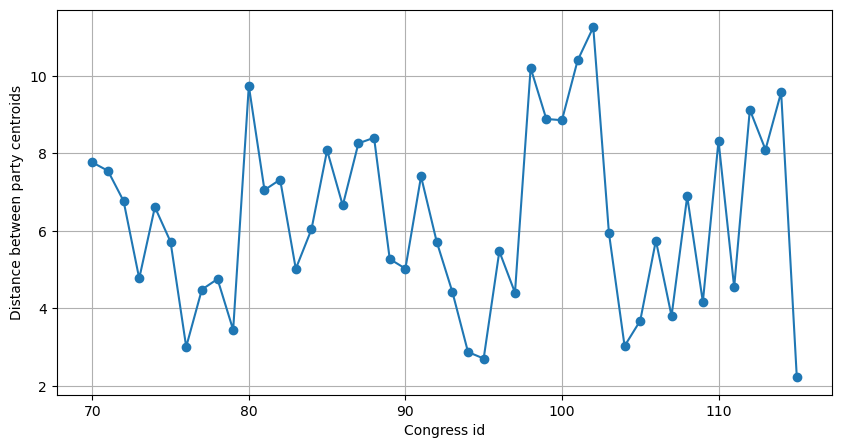

In [369]:
plt.figure(figsize=(10,5))
plt.plot(congress_id, distance_between_party_centroids, "o-")
plt.grid()
plt.xlabel(r"Congress id")
plt.ylabel(r"Distance between party centroids")
plt.show()